In [1]:
import numpy as np
import pandas as pd
import cv2 as cv

In [4]:
original_metadata = pd.read_csv('./data/downloaded_data/diverse/ddidiversedermatologyimages/ddi_metadata.csv')
split_metadata = pd.read_csv('./data/diverse/labels.csv', dtype={'label': int, 'file_name': str})

print(original_metadata.head())
print(split_metadata.head())

   Unnamed: 0  DDI_ID    DDI_file  skin_tone  malignant   
0           0       1  000001.png         56       True  \
1           1       2  000002.png         56       True   
2           2       3  000003.png         56       True   
3           3       4  000004.png         56       True   
4           4       5  000005.png         12       True   

                           disease  
0                 melanoma-in-situ  
1                 melanoma-in-situ  
2                mycosis-fungoides  
3  squamous-cell-carcinoma-in-situ  
4             basal-cell-carcinoma  
  file_name  label
0    000001     56
1    000002     56
2    000003     56
3    000004     56
4    000005     12


In [6]:
original_metadata['skin_tone'].value_counts()

skin_tone
34    241
12    208
56    207
Name: count, dtype: int64

In [7]:
original_metadata = pd.read_csv('./data/downloaded_data/fp17k/fitzpatrick17k.csv')
split_metadata = pd.read_csv('./data/fp17k/labels.csv', dtype={'label': int, 'file_name': str})

print(original_metadata.head())
print(split_metadata.head())

                            md5hash  fitzpatrick_scale  fitzpatrick_centaur   
0  5e82a45bc5d78bd24ae9202d194423f8                  3                    3  \
1  fa2911a9b13b6f8af79cb700937cc14f                  1                    1   
2  d2bac3c9e4499032ca8e9b07c7d3bc40                  2                    3   
3  0a94359e7eaacd7178e06b2823777789                  1                    1   
4  a39ec3b1f22c08a421fa20535e037bba                  1                    1   

                             label nine_partition_label three_partition_label   
0  drug induced pigmentary changes         inflammatory        non-neoplastic  \
1                  photodermatoses         inflammatory        non-neoplastic   
2                   dermatofibroma        benign dermal                benign   
3                        psoriasis         inflammatory        non-neoplastic   
4                        psoriasis         inflammatory        non-neoplastic   

    qc                                

In [3]:
import data.skin_color_dataset as scd
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

dataset = scd.FP17KDataset(subset='train', colorspace='rgb')

0     3
1     1
3     1
5     4
7     5
8     2
9     1
10    2
13    1
14    2
Name: label, dtype: int64
0     34
1     12
3     12
5     34
7     56
8     12
9     12
10    12
13    12
14    12
Name: label, dtype: int64


(3, 256, 256)


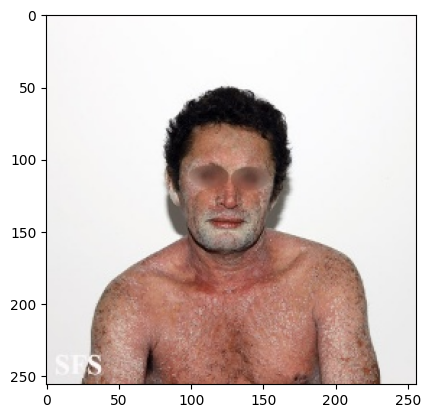

In [79]:
img = dataset.get_item_np(0)
plt.imshow(np.transpose(img, (1, 2, 0)))

print(img.shape)

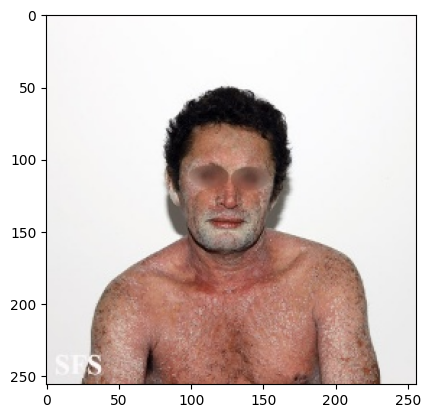

In [83]:
# # skin color thresholding
# 0.0 <= (r-g)/(r+g) <= 0.5

# rg_ratio = (img[0] - img[1]) / (img[0] + img[1] + 1e-6)
# # b / (r+g) <= 0.5
# b_ratio = img[2] / (img[0] + img[1] + 1e-6)
# skin_mask = (b_ratio <= 1)

# Cr ≤ 1.5862 × Cb + 20
# Cr ≥ 0.3448 × Cb + 76.2069
# Cr ≥ -1. × Cb + 234.5652
# Cr ≤ -1.15 × Cb + 301.75
# Cr ≤ -2.2857 × Cb + 432.85
img_ycrcb = cv.cvtColor(np.transpose(img, (1, 2, 0)), cv.COLOR_RGB2YCrCb)
img_ycrcb = np.transpose(img_ycrcb, (2, 0, 1))
img_y = img_ycrcb[0]
img_cr = img_ycrcb[1]
img_cb = img_ycrcb[2]


skin_mask = (img_cr <= 1.5862 * img_cb + 20) & \
            (img_cr >= 0.3448 * img_cb + 76.2069) & \
            (img_cr >= -1. * img_cb + 234.5652) & \
            (img_cr <= -1.15 * img_cb + 301.75) & \
            (img_cr <= -2.2857 * img_cb + 432.85)

img_without_skin = img.copy()
img_without_skin[0][~skin_mask] = 0.0
img_without_skin[1][~skin_mask] = 0.0
img_without_skin[2][~skin_mask] = 0.0

plt.imshow(np.transpose(img_without_skin, (1, 2, 0)))

In [8]:
import pandas as pd

df = pd.read_csv('./data/dermquest/skin_color_prediction.csv')

In [9]:
df.value_counts('skin_type')

skin_type
12    106
34     31
Name: count, dtype: int64

nn_skin_type
12    2488
34     205
56       1
Name: count, dtype: int64


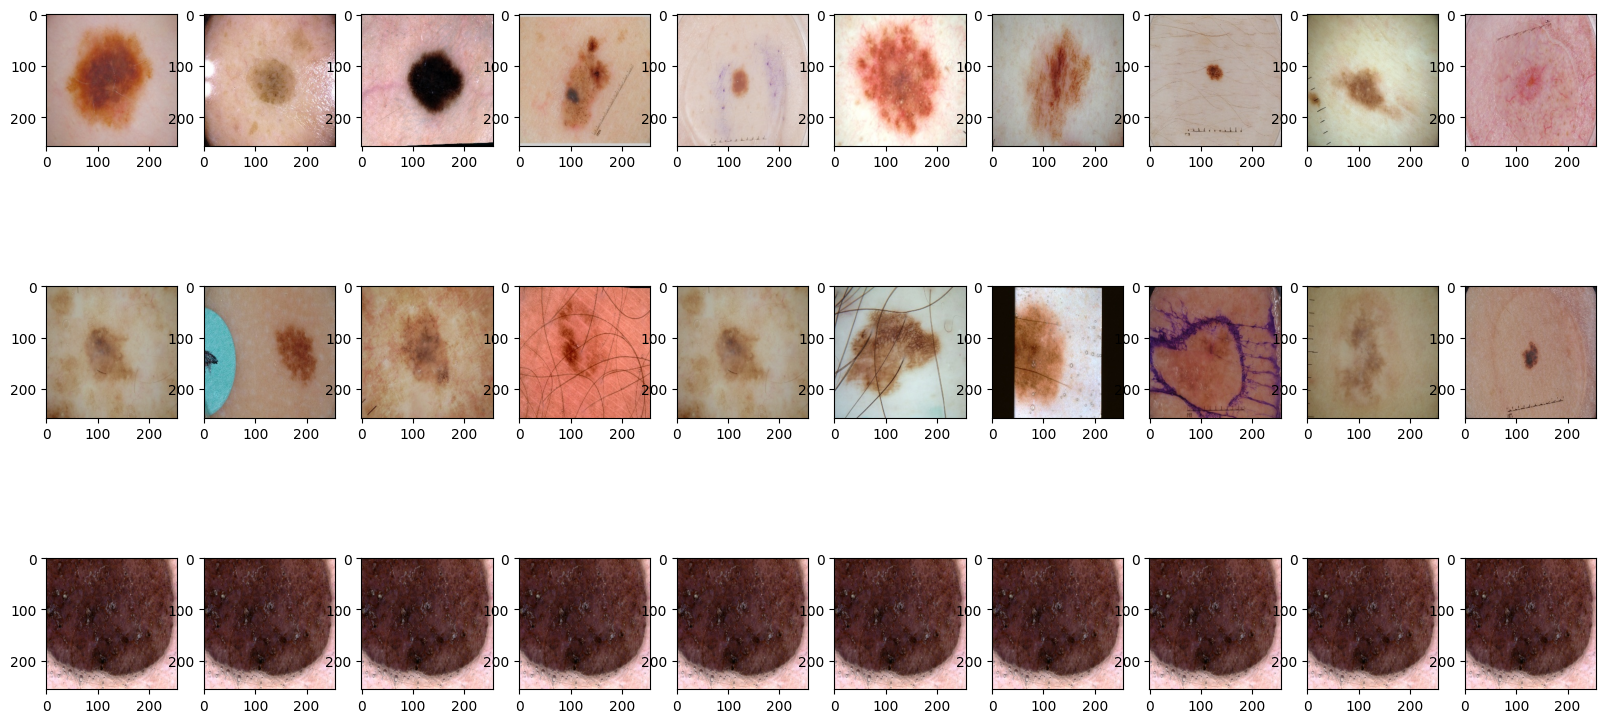

nn_skin_type
12    61
34     6
56     2
Name: count, dtype: int64


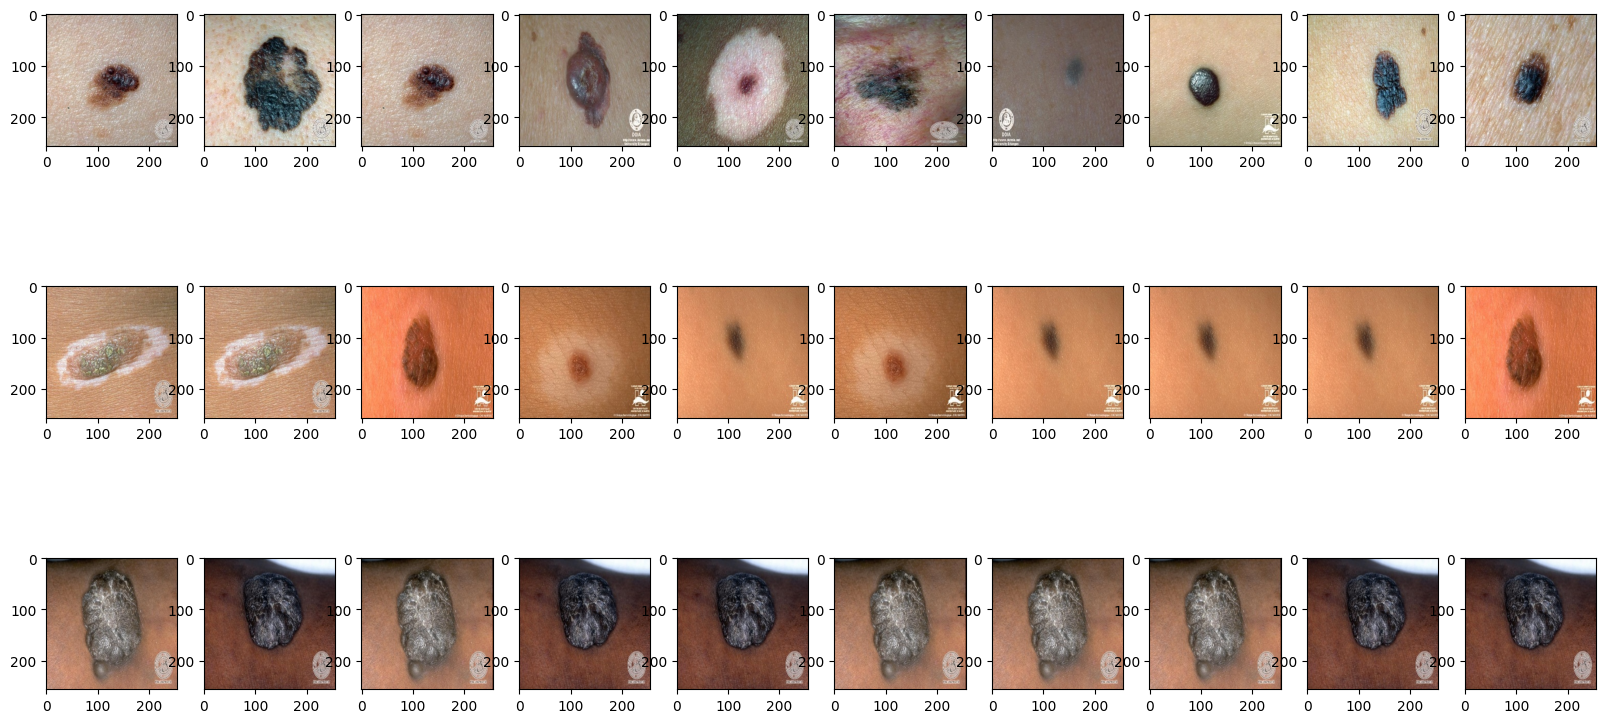

nn_skin_type
12    93
34    43
56     1
Name: count, dtype: int64


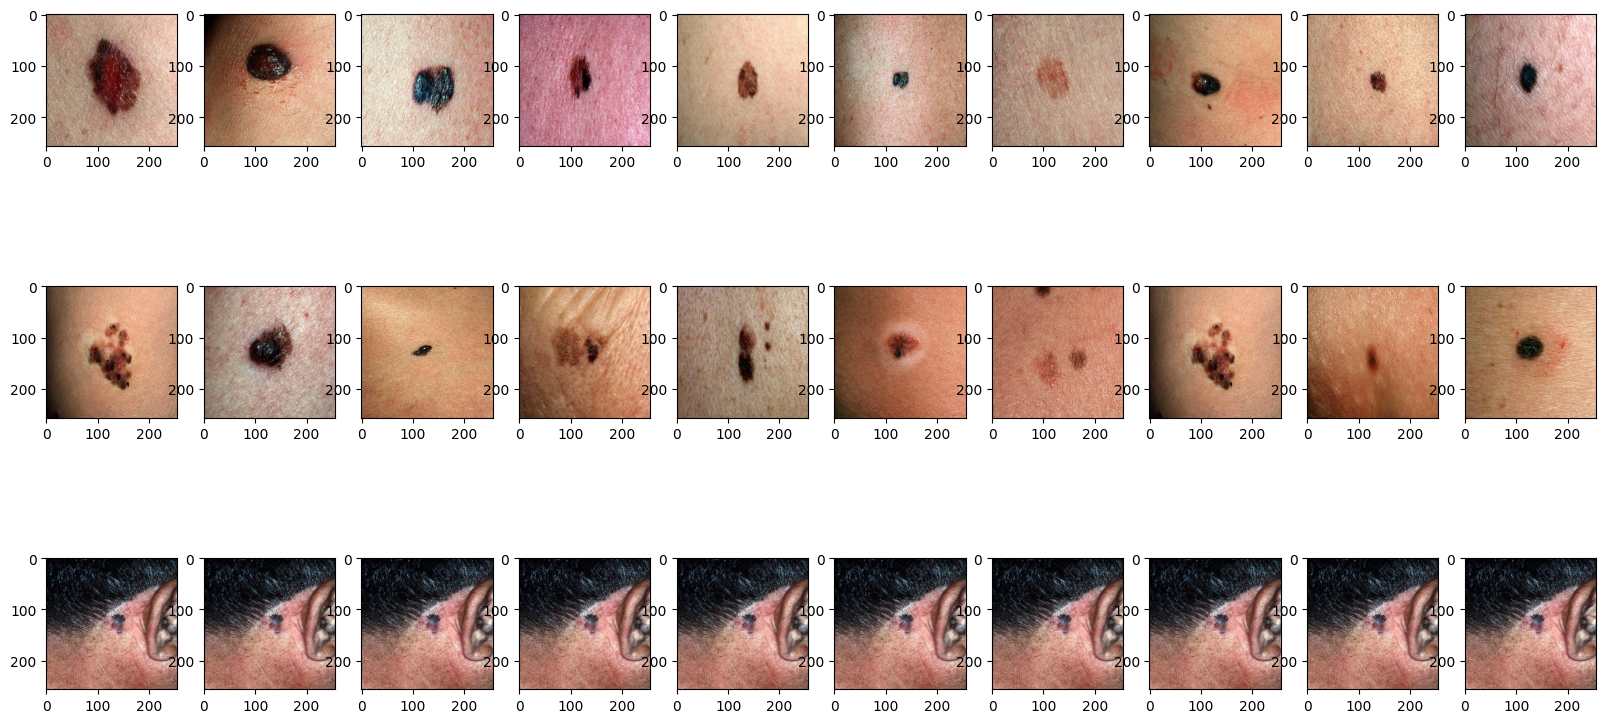

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import cv2 as cv
from pathlib import Path

datasets = ['isic', 'dermis', 'dermquest']
labels = [12, 34, 56]


for dataset in datasets:
    fig, axs = plt.subplots(3, 10, figsize=(20, 10))
    df = pd.read_csv(f'./data/{dataset}/skin_color_prediction.csv')
    print(df['nn_skin_type'].value_counts())
    for label in labels:
        # plot 10 images of each class
        df_ = df[df['nn_skin_type'] == label]
        if len(df_) == 0:
            continue
        df_ = df_.sample(10, replace=True)
        for i in range(10):
            row = df_.iloc[i]
            file_path = Path(f'./data/{dataset}')
            file_path = list(file_path.glob(f'**/{row["file_name"]}*'))[0]
            img = cv.imread(str(file_path))
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            axs[labels.index(label)][i].imshow(img)
    plt.show()

In [56]:
from typing import Optional, Literal

import cv2 as cv
import numpy as np
import kneed
import matplotlib.pyplot as plt

viz_imgs = []

def find_dominant_color(img: np.ndarray, label: Optional[np.ndarray] = None) -> np.ndarray:
    """
    Finds the dominant color of the skin in the image.

    Args:
        img: The BGR image to find the dominant color of.
        label: The label of the image. If provided, the dominant color will be found only in the skin area.
    
    Returns:
        The dominant color of the skin in the image as (R, G, B) or (-1, -1, -1) if the dominant color could not be found.
    """
    processed_img = extract_skin(img, label)
    try:
      dominant_color = kmeans_with_kneed_dominant_color(processed_img)
    except Exception as e:
      print('Error processing file: ', e)
      return np.array((-1, -1, -1))
    return dominant_color

def get_fitzpatrick_type(ita_angle: float) -> Literal[12, 34, 56]:
    if ita_angle >= 41:
        return 12
    elif ita_angle >= 19:
        return 34
    else:
        return 56

def get_ita_angle(color_rgb: np.ndarray) -> float:
  color_lab = cv.cvtColor(np.uint8([[color_rgb]]), cv.COLOR_RGB2LAB)[0][0]
  return np.arctan((color_lab[0] - 50) / color_lab[2]) * 180 / np.pi

def extract_skin(img: np.ndarray, label: Optional[np.ndarray] = None) -> np.ndarray:
  """
  Extracts the skin from the image using the label and additional processing
  including DullRazor, CLAHE and thresholding.
  """
  clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  lab = cv.cvtColor(img, cv.COLOR_BGR2LAB)
  lab_planes = list(cv.split(lab))
  lab_planes[0] = clahe.apply(lab_planes[0])
  lab = cv.merge(lab_planes)
  clahe_img = cv.cvtColor(lab, cv.COLOR_LAB2BGR)

  hair_mask = get_hair_mask(clahe_img)
  if label is None:
    label = np.zeros_like(hair_mask)
  mask_all = 255 - np.bitwise_or(hair_mask, label)
  masked_img = cv.bitwise_and(clahe_img, clahe_img, mask=255 - mask_all)

  viz_imgs.append(masked_img)

  # threshold to remove pigmentations
  hsv = cv.cvtColor(masked_img, cv.COLOR_BGR2HSV)
  _, _, v = cv.split(hsv)
  v = cv.GaussianBlur(v, (5, 5), 0)
  _, v_thresh = cv.threshold(v, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
  thresh = v_thresh

  # expand
  kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
  thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations=5)
  thresh = cv.dilate(thresh, kernel, iterations=5)
  thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel, iterations=5)

  final_image = cv.bitwise_and(clahe_img, clahe_img, mask=255 - thresh)

  viz_imgs.append(final_image)
  return final_image

def get_hair_mask(img):
  grayscale = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
  kernel = cv.getStructuringElement(1, (2,2))
  blackhat = cv.morphologyEx(grayscale, cv.MORPH_BLACKHAT, kernel)
  blurred = cv.GaussianBlur(blackhat, (3,3), cv.BORDER_DEFAULT)
  _, hair_mask = cv.threshold(blurred, 5, 255, cv.THRESH_BINARY)
  return hair_mask

def dull_razor(img):
  """
  Applies the DullRazor algorithm to the image.
  img should be an RGB numpy array of shape (H, W, C) between 0 and 255.
  """
  viz_imgs.append(img)
  hair_mask = get_hair_mask(img)
  result = cv.inpaint(img, hair_mask, 6, cv.INPAINT_TELEA)
  viz_imgs.append(result)
  #show_images_row(imgs=[img, hair_mask, result], titles=['Original', 'Hair Mask', 'Result'], figsize=(10, 5))
  return result

def kmeans_dominant_color(processed_img, k):
  processed_img_rgb = cv.cvtColor(processed_img, cv.COLOR_BGR2RGB)
  pixel_values = processed_img_rgb.reshape((-1, 3))
  pixel_values = np.float32(pixel_values)
  pixel_values = pixel_values[np.where(pixel_values[:, 0] > 0)]
  criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.2)
  compactness, labels, (centers) = cv.kmeans(pixel_values, k, None, criteria, 10, cv.KMEANS_PP_CENTERS)
  centers = np.uint8(centers)
  labels = labels.flatten()
  dominant_label = np.argmax(np.bincount(labels))
  dominant_color = centers[dominant_label]
  dominant_color = np.array(dominant_color).astype(int)
  return dominant_color, compactness

def kmeans_dominant_color_lab(processed_img, k):
  processed_img_lab = cv.cvtColor(processed_img, cv.COLOR_BGR2LAB)
  pixel_values = processed_img_lab.reshape((-1, 3))
  # remove black pixels
  pixel_values = pixel_values[np.where(pixel_values[:, 0] > 0)]
  # keep only a and b channels
  #pixel_values = pixel_values[:, 1:]
  pixel_values = np.float32(pixel_values)

  criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.2)
  compactness, labels, (centers) = cv.kmeans(pixel_values, k, None, criteria, 10, cv.KMEANS_PP_CENTERS)
  centers = np.uint8(centers)
  labels = labels.flatten()

  dominant_label = np.argmax(np.bincount(labels))
  dominant_color = centers[dominant_label]
  dominant_color = np.array(dominant_color)
  dominant_color = np.round(dominant_color).astype(int)
  # add back L channel
  dominant_color = cv.cvtColor(np.uint8([[dominant_color]]), cv.COLOR_LAB2RGB)
  return dominant_color, compactness

def mean_dominant_color(processed_img):
  processed_img_rgb = cv.cvtColor(processed_img, cv.COLOR_BGR2RGB)
  pixel_values = processed_img_rgb.reshape((-1, 3))
  pixel_values = np.float32(pixel_values)
  pixel_values = pixel_values[np.where(pixel_values[:, 0] > 0)]
  mean_color = np.mean(pixel_values, axis=0)
  mean_color = np.array(mean_color).astype(int)
  return mean_color

def kmeans_with_kneed_dominant_color(processed_img):
  ks = range(2, 10)
  colors, compactnesses = zip(*[kmeans_dominant_color_lab(processed_img, k) for k in ks])
  kneedle = kneed.KneeLocator(ks, compactnesses, S=1.0, curve='convex', direction='decreasing')
  dominant_color = colors[kneedle.elbow]
  return dominant_color

[ WARN:0@2291.104] global loadsave.cpp:248 findDecoder imread_('./data/isic/train/label/ISIC_0003728.png'): can't open/read file: check file path/integrity


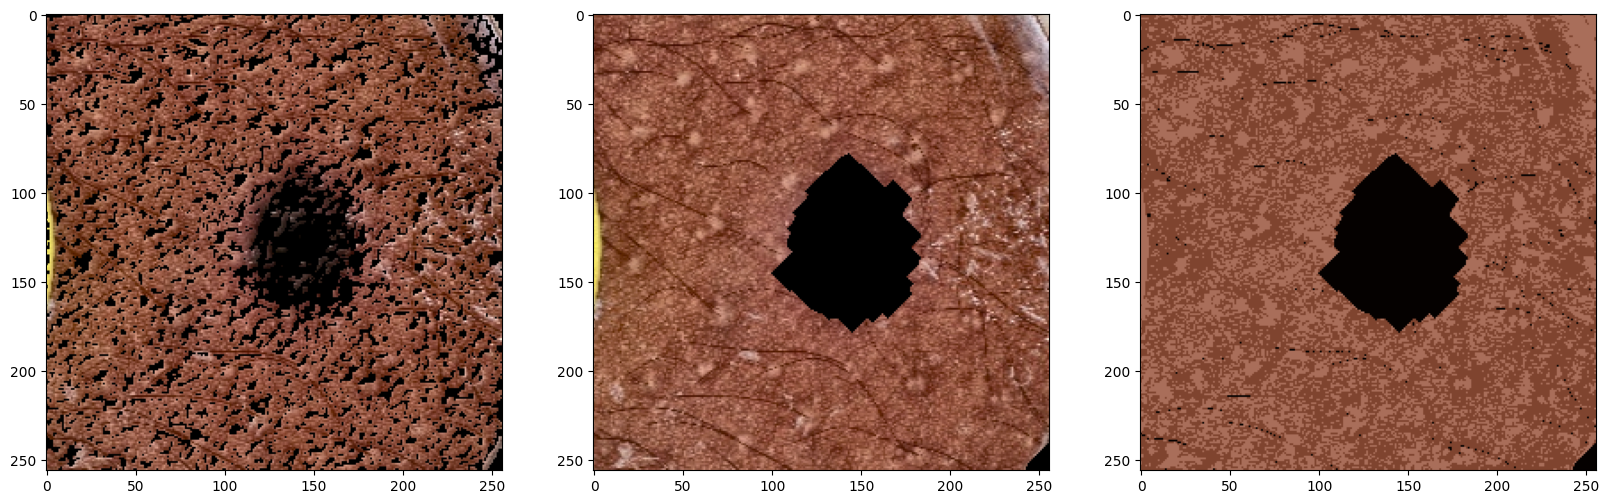

In [59]:
img = cv.imread('./data/isic/train/input/ISIC_0003728.jpg')
label = cv.imread('./data/isic/train/label/ISIC_0003728.png')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
# crop left 50 pixels out of the image
img = img[:, 50:, :]
# resize to 256x256
img = cv.resize(img, (256, 256))

viz_imgs = []
img_processed = extract_skin(img, label)

# show viz images
pixel_values = img_processed.reshape((-1, 3))
pixel_values = np.float32(pixel_values)
k = 3
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.2)
compactness, labels, (centers) = cv.kmeans(pixel_values, k, None, criteria, 10, cv.KMEANS_PP_CENTERS)
centers = np.uint8(centers)
labels = labels.flatten()

viz_img = centers[labels]
viz_img = viz_img.reshape(img_processed.shape)
viz_imgs.append(viz_img)

# show viz images
fig, axs = plt.subplots(1, len(viz_imgs), figsize=(20, 10))
for i, img in enumerate(viz_imgs):
  axs[i].imshow(img)

# save viz images
save_loc = './figures/'
names = ['skin_mask.png', 'processed_img.png', 'kmeans_img.png']
for i, img in enumerate(viz_imgs):
  img_ = cv.cvtColor(img, cv.COLOR_RGB2BGR)
  cv.imwrite(save_loc + names[i], img_)
